In [ ]:
# connect to google drive, run this block again after every restart of runtime
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Indoor_model_1118')

Mounted at /content/drive


In [ ]:
import os
import h5py
import time
import csv
import glob

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras

from numpy import load
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ELU
from tensorflow.keras.activations import linear
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import matplotlib
from matplotlib import pyplot
import matplotlib.pylab as plt
import seaborn as sns

In [ ]:
# review (only review) GPU information, run when needed
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug 25 14:20:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# define an encoder block
def encoder_block(layer_in, n_filters, strd=(2,2,2), batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, strd=(2,2,2), dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [ ]:
# define the standalone generator model
def define_generator(bnd_image_shape=(32,32,16,5), mag_image_shape=(32,32,16,1), delta_feature_shape=(3,)):
# def define_generator(src_image_shape=(32,32,16,5)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=bnd_image_shape) # 32*32*16*5
    in_mag = Input(shape=mag_image_shape) # 32*32*16*1
    in_delta = Input(shape=delta_feature_shape) # 3

    in_concat = Concatenate()([in_image, in_mag]) # 32*32*16*6

    # encoder model
    e0 = encoder_block(in_concat, 512, strd=(1,1,1), batchnorm=True) # 32*32*16*512
    e1 = encoder_block(e0, 512, strd=(1,1,1), batchnorm=True) # 32*32*16*512
    e2 = encoder_block(e1, 512, strd=(1,1,1), batchnorm=True) # 32*32*16*512
    e3 = encoder_block(e2, 512, strd=(2,2,2), batchnorm=True) # 16*16*8*512
    e4 = encoder_block(e3, 512, strd=(1,1,1), batchnorm=True) # 16*16*8*512
    e4_ = encoder_block(e4, 512, strd=(1,1,1), batchnorm=True) # 16*16*8*512
    e5 = encoder_block(e4_, 512, strd=(2,2,2), batchnorm=True) # 8*8*4*512
    e6 = encoder_block(e5, 512, strd=(1,1,1), batchnorm=True) # 8*8*4*512
    e6_ = encoder_block(e6, 512, strd=(1,1,1), batchnorm=True) # 8*8*4*512
    e7 = encoder_block(e6_, 512, strd=(2,2,2), batchnorm=True) # 4*4*2*512
    e8 = encoder_block(e7, 512, strd=(1,1,1), batchnorm=True) # 4*4*2*512
    e8_ = encoder_block(e8, 512, strd=(1,1,1), batchnorm=True) # 4*4*2*512
    e9 = encoder_block(e8_, 512, strd=(2,2,2), batchnorm=True) # 2*2*1*512
    e10 = encoder_block(e9, 512, strd=(1,1,1), batchnorm=True) # 2*2*1*512
    e10_ = encoder_block(e10, 512, strd=(1,1,1), batchnorm=True) # 2*2*1*512
    f = Flatten()(e10_) # 2048

    # bottleneck, no batch norm and relu
    b0 = Concatenate(axis=-1)([f, in_delta]) # 2051
    b1 = Dense(2048, activation='relu')(b0)
    b2 = Dense(2048, activation='relu')(b1)
    b3 = Reshape((2,2,1,512))(b2) # 2*2*1*512

    # decoder model
    d9 = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(b3)  # 2*2*1*512
    d9 = BatchNormalization()(d9)
    d9 = Dropout(0.5)(d9)
    d9 = LeakyReLU(alpha=0.2)(d9)

    d9_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d9)  # 2*2*1*512
    d9_ = BatchNormalization()(d9_)
    d9_ = Dropout(0.5)(d9_)
    d9_ = LeakyReLU(alpha=0.2)(d9_)

    d8 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d9_)  # 4*4*2*512
    d8 = BatchNormalization()(d8)
    d8 = Dropout(0.5)(d8)
    d8 = LeakyReLU(alpha=0.2)(d8)

    d8_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d8)  # 4*4*2*512
    d8_ = BatchNormalization()(d8_)
    d8_ = Dropout(0.5)(d8_)
    d8_ = LeakyReLU(alpha=0.2)(d8_)

    d7 = decoder_block(d8_, e7, 512, strd=(1,1,1), dropout=True) # 4*4*2*1024

    d6 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d7)  # 8*8*4*512
    d6 = BatchNormalization()(d6)
    d6 = Dropout(0.5)(d6)
    d6 = LeakyReLU(alpha=0.2)(d6)

    d6_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d6)  # 8*8*4*512
    d6_ = BatchNormalization()(d6_)
    d6_ = Dropout(0.5)(d6_)
    d6_ = LeakyReLU(alpha=0.2)(d6_)

    d5 = decoder_block(d6_, e5, 512, strd=(1,1,1), dropout=True) # 8*8*4*1024

    d4 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d5)  # 16*16*8*512
    d4 = BatchNormalization()(d4)
    d4 = Dropout(0.5)(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)

    d4_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d4)  # 16*16*8*512
    d4_ = BatchNormalization()(d4_)
    d4_ = Dropout(0.5)(d4_)
    d4_ = LeakyReLU(alpha=0.2)(d4_)

    d3 = decoder_block(d4_, e3, 512, strd=(1,1,1), dropout=True) # 16*16*8*1024

    d2 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d3) # 32*32*16*512
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.5)(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)

    d1 = decoder_block(d2, e1, 512, strd=(1,1,1), dropout=True) # 32*32*16*1024

    d0 = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d1) # 32*32*16*512
    d0 = BatchNormalization()(d0)
    d0 = Dropout(0.5)(d0)
    d0 = LeakyReLU(alpha=0.2)(d0)

    d0_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d0) # 32*32*16*512
    d0_ = BatchNormalization()(d0_)
    d0_ = Dropout(0.5)(d0_)
    d0_ = LeakyReLU(alpha=0.2)(d0_)

    # output
    out_image = Conv3DTranspose(4, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d0_) # 32*32*16*4

    # define model
    model = Model([in_image, in_mag, in_delta], out_image)

    print("Generator Summary: \n")
    model.summary(positions = [.4, .68, .8, 1.])
    return model

In [ ]:
# dataset pipeline
def get_data_from_filename(filename):
    npdata = np.load(filename.numpy())
    bnd_mx, mag_mx, xyz_deltas, cfd_mx = npdata['arr_0'], npdata['arr_1'], npdata['arr_2'], npdata['arr_3']
    uvw_scaler = 1/7.0
    p_scaler = 1/25.0
    bnd_mx[:,:,:,0] *= uvw_scaler
    bnd_mx[:,:,:,1] *= uvw_scaler
    bnd_mx[:,:,:,2] *= uvw_scaler
    bnd_mx[:,:,:,3] *= p_scaler
    mag_mx[:,:,:,0] *= uvw_scaler
    cfd_mx[:,:,:,0] *= uvw_scaler
    cfd_mx[:,:,:,1] *= uvw_scaler
    cfd_mx[:,:,:,2] *= uvw_scaler
    cfd_mx[:,:,:,3] *= p_scaler
    return bnd_mx, mag_mx, xyz_deltas, cfd_mx

def get_data_wrapper(filename):
    # Assuming here that both your data and label is float type.
    bnd_mx, mag_mx, xyz_deltas, cfd_mx = tf.py_function(get_data_from_filename, [filename], [tf.float32, tf.float32, tf.float32, tf.float32])
    return tf.data.Dataset.from_tensors((bnd_mx, mag_mx, xyz_deltas, cfd_mx))

def set_shape(m1, mm, d, m2):
    m1.set_shape((32, 32, 16, 5))
    mm.set_shape((32, 32, 16, 1))
    d.set_shape((3,))
    m2.set_shape((32, 32, 16, 4))
    return m1, mm, d, m2

# Create dataset of filenames.
test_percent = 0.01
batch_size = 16
npz_folder_path = "/content/drive/MyDrive/Indoor_model_1118/Indoor_Dataset_D/Mag_High_Res_Dataset"
filelist = glob.glob(npz_folder_path + '/*.npz')
train_num = int((len(filelist)/batch_size)*(1.0-test_percent))
print("number of data point in training set: ", train_num)
ds = tf.data.Dataset.from_tensor_slices(filelist)
ds = ds.flat_map(get_data_wrapper)
ds = ds.map(set_shape)
ds = ds.batch(batch_size)
ds_train = ds.take(train_num)
ds_test = ds.skip(train_num)

number of data point in training set:  742


dx:  0.25
dy:  0.14516129
dz:  0.2


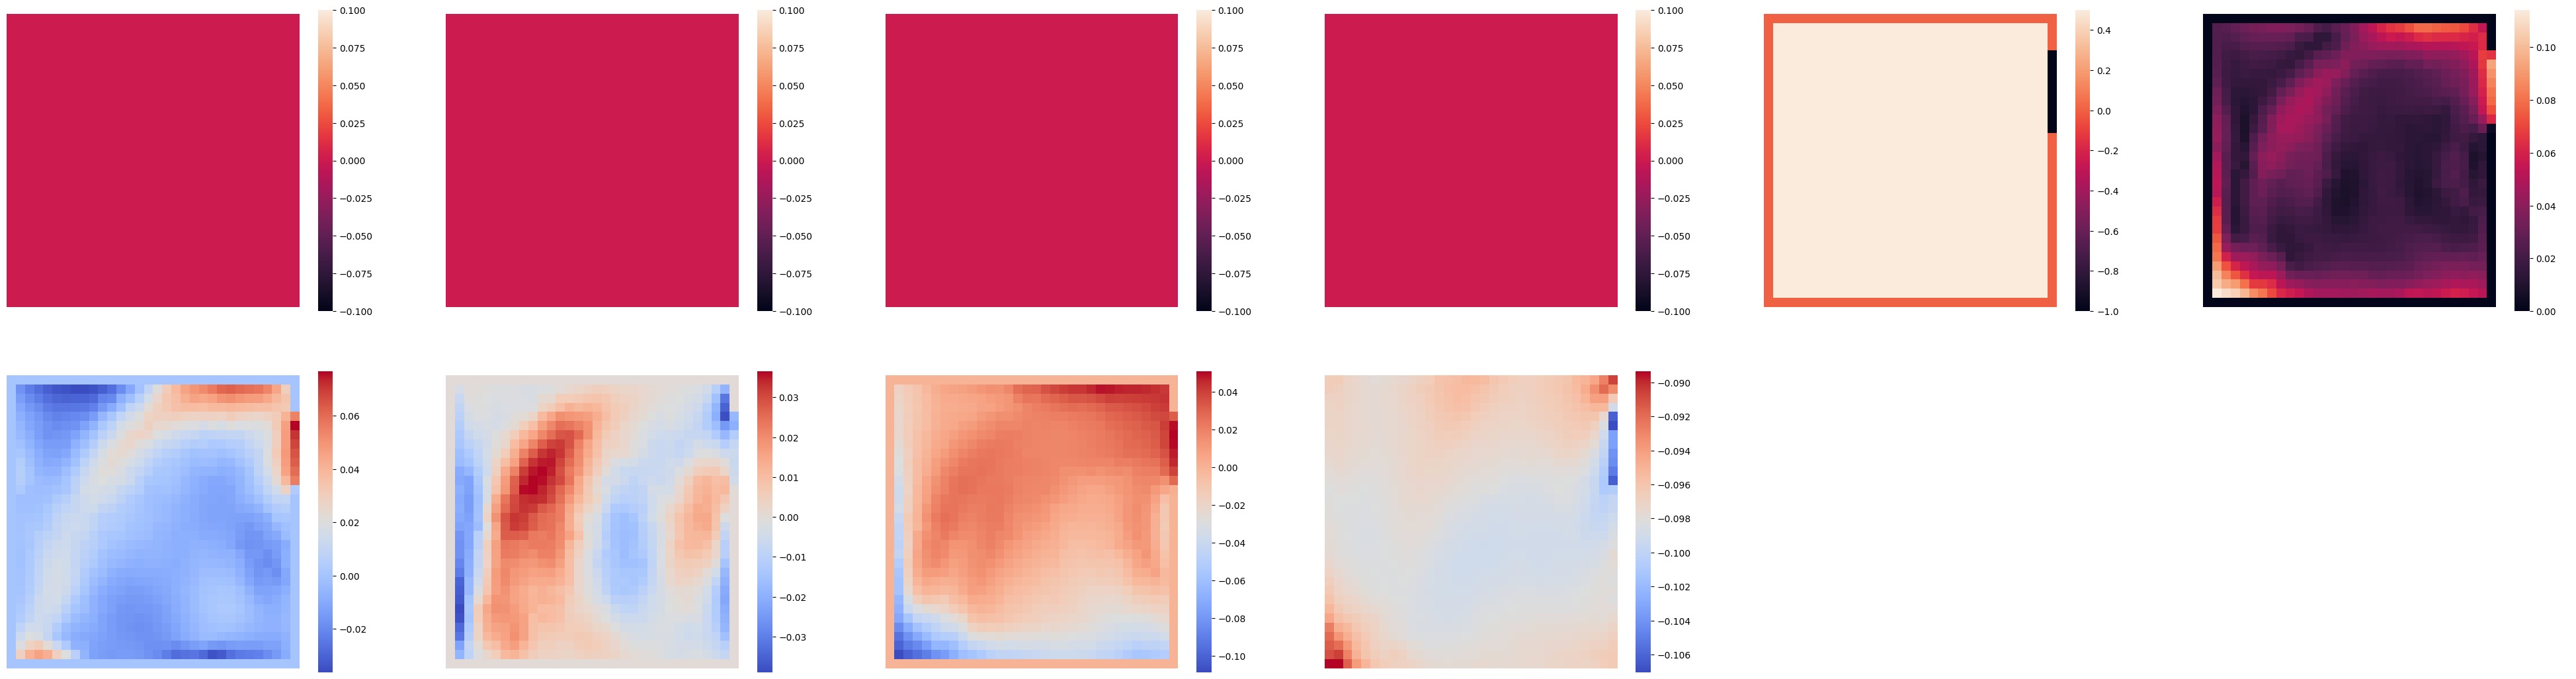

In [ ]:
# print data example
z = 8
for bnd_mx, mag_mx, xyz_deltas, cfd_mx in ds_test.skip(2).take(1):
    print("dx: ", xyz_deltas.numpy()[0,0])
    print("dy: ", xyz_deltas.numpy()[0,1])
    print("dz: ", xyz_deltas.numpy()[0,2])
    ub, vb, wb, pb, patb, magc = bnd_mx.numpy()[0,:,:,:,0], bnd_mx.numpy()[0,:,:,:,1], bnd_mx.numpy()[0,:,:,:,2], bnd_mx.numpy()[0,:,:,:,3], bnd_mx.numpy()[0,:,:,:,4], mag_mx.numpy()[0,:,:,:,0]
    uc, vc, wc, pc = cfd_mx.numpy()[0,:,:,:,0], cfd_mx.numpy()[0,:,:,:,1], cfd_mx.numpy()[0,:,:,:,2], cfd_mx.numpy()[0,:,:,:,3]

    fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(50, 13))
    sns.heatmap(ub[:,:,z].T, ax = ax[0,0], square = True)
    ax[0,0].invert_yaxis()
    ax[0,0].axis('off')
    sns.heatmap(vb[:,:,z].T, ax = ax[0,1], square = True)
    ax[0,1].invert_yaxis()
    ax[0,1].axis('off')
    sns.heatmap(wb[:,:,z].T, ax = ax[0,2], square = True)
    ax[0,2].invert_yaxis()
    ax[0,2].axis('off')
    sns.heatmap(pb[:,:,z].T, ax = ax[0,3], square = True)
    ax[0,3].invert_yaxis()
    ax[0,3].axis('off')
    sns.heatmap(patb[:,:,z].T, ax = ax[0,4], square = True)
    ax[0,4].invert_yaxis()
    ax[0,4].axis('off')
    sns.heatmap(magc[:,:,z].T, ax = ax[0,5], square = True)
    ax[0,5].invert_yaxis()
    ax[0,5].axis('off')

    sns.heatmap(uc[:,:,z].T, ax = ax[1,0], square = True, cmap="coolwarm")
    ax[1,0].invert_yaxis()
    ax[1,0].axis('off')
    sns.heatmap(vc[:,:,z].T, ax = ax[1,1], square = True, cmap="coolwarm")
    ax[1,1].invert_yaxis()
    ax[1,1].axis('off')
    sns.heatmap(wc[:,:,z].T, ax = ax[1,2], square = True, cmap="coolwarm")
    ax[1,2].invert_yaxis()
    ax[1,2].axis('off')
    sns.heatmap(pc[:,:,z].T, ax = ax[1,3], square = True, cmap="coolwarm")
    ax[1,3].invert_yaxis()
    ax[1,3].axis('off')
    ax[1,4].axis('off')
    ax[1,5].axis('off')

In [ ]:
generator = define_generator()
generator_optimizer = Adam(0.000002, beta_1=0.9) # lr start as 0.00002 #145 0.000002

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Generator Summary: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #     Connected to        
 input_1 (InputLayer)                  [(None, 32, 32, 16, 5)]    0           []                  
                                                                                                  
 input_2 (InputLayer)                  [(None, 32, 32, 16, 1)]    0           []                  
                                                                                                  
 concatenate (Concatenate)             (None, 32, 32, 16, 6)      0           ['input_1[0][0]',   
                                                                               'input_2[0][0]']   
                                                                                                  
 conv3d (Conv3D)                       (None, 32, 32, 16, 512)    83456  

In [ ]:
@tf.function
def resnet_train_iteration(bnd, mag, delta, cfd):
    with tf.GradientTape() as gen_tape:
        generated_images = generator([bnd, mag, delta], training=True)

        loss_factor = 10.0
        gen_loss = MeanAbsoluteError()(generated_images, cfd, sample_weight=K.abs(tf.subtract(bnd[:,:,:,:,4], 0.25))) * loss_factor

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss

In [ ]:
def train(dataset, epochs, starting_epoch):
    f = open("/content/drive/MyDrive/Indoor_model_1118/Indoor_model_loss_uvwp_0801/Indoor_model_loss_uvwp_0801_" + str(starting_epoch) + ".csv", "w")
    writer = csv.writer(f)
    writer.writerow(list(range(train_num)))
    f.close()

    for epoch in range(epochs):
        train_loss = []
        start = time.time()
        for i, (bnd_mx, mag_mx, xyz_deltas, cfd_mx) in enumerate(dataset):
            gen_loss = resnet_train_iteration(bnd_mx, mag_mx, xyz_deltas, cfd_mx)
            print('>%d, g[%.5f]' % (i+1, gen_loss))
            train_loss.append(gen_loss.numpy())
        with open('/content/drive/MyDrive/Indoor_model_1118/Indoor_model_loss_uvwp_0801/Indoor_model_loss_uvwp_0801_' + str(starting_epoch) + '.csv', 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(train_loss)

        # save the model every 10 epochs
        if (epoch+1) % 5 == 0:
            g_filename = '/content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_uvwp/Indoor_model_uvwp_0801_%06d.h5' % (starting_epoch+epoch+1)
            generator.save(g_filename)
            print('>save g_model: %s' % (g_filename))

        print('Time for epoch {} is {} sec'.format(starting_epoch + epoch + 1, time.time()-start))

In [ ]:
train(ds_train, epochs=50, starting_epoch=250)

>1, g[0.02253]
>2, g[0.02353]
>3, g[0.02452]
>4, g[0.02705]
>5, g[0.02444]
>6, g[0.02208]
>7, g[0.02838]
>8, g[0.02376]
>9, g[0.01984]
>10, g[0.02574]
>11, g[0.02905]
>12, g[0.02286]
>13, g[0.02386]
>14, g[0.02263]
>15, g[0.02622]
>16, g[0.02033]
>17, g[0.02246]
>18, g[0.02120]
>19, g[0.02606]
>20, g[0.02233]
>21, g[0.02305]
>22, g[0.02310]
>23, g[0.02562]
>24, g[0.01981]
>25, g[0.02563]
>26, g[0.01872]
>27, g[0.02310]
>28, g[0.02167]
>29, g[0.02422]
>30, g[0.02181]
>31, g[0.02177]
>32, g[0.02267]
>33, g[0.02416]
>34, g[0.02211]
>35, g[0.02495]
>36, g[0.02198]
>37, g[0.02074]
>38, g[0.02543]
>39, g[0.02501]
>40, g[0.02431]
>41, g[0.02426]
>42, g[0.02375]
>43, g[0.02514]
>44, g[0.02313]
>45, g[0.02062]
>46, g[0.02176]
>47, g[0.02090]
>48, g[0.02593]
>49, g[0.02019]
>50, g[0.02711]
>51, g[0.02695]
>52, g[0.02542]
>53, g[0.02147]
>54, g[0.02171]
>55, g[0.02151]
>56, g[0.02335]
>57, g[0.02219]
>58, g[0.02673]
>59, g[0.02495]
>60, g[0.02731]
>61, g[0.02068]
>62, g[0.02309]
>63, g[0.02288]
>

>742, g[0.02442]
>save g_model: /content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_uvwp/Indoor_model_uvwp_0801_000235.h5
Time for epoch 235 is 667.2329657077789 sec
>1, g[0.02271]
>2, g[0.02344]
>3, g[0.02505]
>4, g[0.02573]
>5, g[0.02286]
>6, g[0.02206]
>7, g[0.02938]
>8, g[0.02285]
>9, g[0.01905]
>10, g[0.02750]
>11, g[0.02874]
>12, g[0.02103]
>13, g[0.02346]
>14, g[0.02310]
>15, g[0.02538]
>16, g[0.02100]
>17, g[0.02561]
>18, g[0.02190]
>19, g[0.02536]
>20, g[0.02120]
>21, g[0.02338]
>22, g[0.02329]
>23, g[0.02524]
>24, g[0.01875]
>25, g[0.02714]
>26, g[0.01903]
>27, g[0.02201]
>28, g[0.02216]
>29, g[0.02302]
>30, g[0.02249]
>31, g[0.02130]
>32, g[0.02405]
>33, g[0.02414]
>34, g[0.03124]
>35, g[0.02342]
>36, g[0.02401]
>37, g[0.02033]
>38, g[0.02323]
>39, g[0.02182]
>40, g[0.02332]
>41, g[0.02388]
>42, g[0.02379]
>43, g[0.02433]
>44, g[0.02318]
>45, g[0.02040]
>46, g[0.02158]
>47, g[0.02030]
>48, g[0.02394]
>49, g[0.01939]
>50, g[0.02572]
>51, g[0.02506]
>52, g[0.02529]
>53

>742, g[0.02372]
>save g_model: /content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_uvwp/Indoor_model_uvwp_0801_000240.h5
Time for epoch 240 is 667.0831475257874 sec
>1, g[0.02196]
>2, g[0.02540]
>3, g[0.02524]
>4, g[0.02402]
>5, g[0.02229]
>6, g[0.02194]
>7, g[0.02830]
>8, g[0.02274]
>9, g[0.02001]
>10, g[0.02534]
>11, g[0.02876]
>12, g[0.02095]
>13, g[0.02357]
>14, g[0.02583]
>15, g[0.02464]
>16, g[0.02077]
>17, g[0.02287]
>18, g[0.02182]
>19, g[0.02262]
>20, g[0.02191]
>21, g[0.02351]
>22, g[0.02257]
>23, g[0.02734]
>24, g[0.01883]
>25, g[0.02491]
>26, g[0.01836]
>27, g[0.02188]
>28, g[0.02495]
>29, g[0.02396]
>30, g[0.02207]
>31, g[0.02419]
>32, g[0.02320]
>33, g[0.02649]
>34, g[0.02273]
>35, g[0.02439]
>36, g[0.02165]
>37, g[0.02020]
>38, g[0.02419]
>39, g[0.02082]
>40, g[0.02371]
>41, g[0.02426]
>42, g[0.02346]
>43, g[0.02544]
>44, g[0.02290]
>45, g[0.02080]
>46, g[0.02263]
>47, g[0.02119]
>48, g[0.02350]
>49, g[0.01914]
>50, g[0.02484]
>51, g[0.02703]
>52, g[0.02487]
>53

>742, g[0.02322]
>save g_model: /content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_uvwp/Indoor_model_uvwp_0801_000245.h5
Time for epoch 245 is 667.7672810554504 sec
>1, g[0.02274]
>2, g[0.02317]
>3, g[0.02424]
>4, g[0.02381]
>5, g[0.02248]
>6, g[0.02208]
>7, g[0.02806]
>8, g[0.02311]
>9, g[0.01868]
>10, g[0.02476]
>11, g[0.02789]
>12, g[0.02089]
>13, g[0.02342]
>14, g[0.02248]
>15, g[0.02293]
>16, g[0.02029]
>17, g[0.02357]
>18, g[0.02228]
>19, g[0.02244]
>20, g[0.02235]
>21, g[0.02301]
>22, g[0.02517]
>23, g[0.02881]
>24, g[0.01846]
>25, g[0.02522]
>26, g[0.01838]
>27, g[0.02497]
>28, g[0.02156]
>29, g[0.02301]
>30, g[0.02282]
>31, g[0.02128]
>32, g[0.02299]
>33, g[0.02491]
>34, g[0.02197]
>35, g[0.02225]
>36, g[0.02174]
>37, g[0.02088]
>38, g[0.02388]
>39, g[0.02130]
>40, g[0.02450]
>41, g[0.02386]
>42, g[0.02315]
>43, g[0.02486]
>44, g[0.02296]
>45, g[0.02034]
>46, g[0.02092]
>47, g[0.02152]
>48, g[0.02459]
>49, g[0.01993]
>50, g[0.02841]
>51, g[0.02465]
>52, g[0.02552]
>53

>742, g[0.02357]
>save g_model: /content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_uvwp/Indoor_model_uvwp_0801_000250.h5
Time for epoch 250 is 667.3811681270599 sec


In [ ]:
g_filename = "/content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_uvwp/Indoor_model_uvwp_0801_000250.h5"
generator = load_model(g_filename, compile=False)

1/1 [==============================] - 10s 10s/step


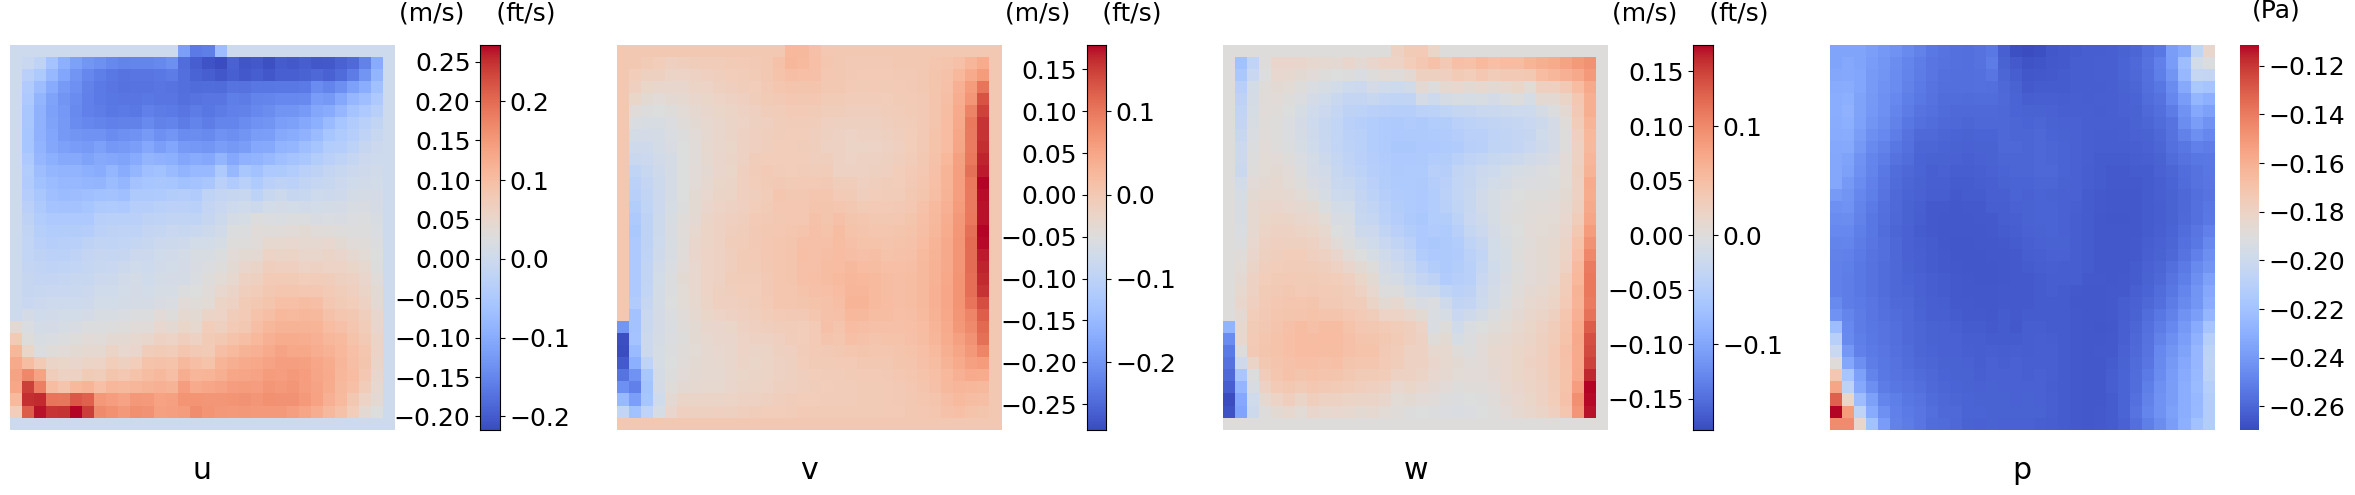

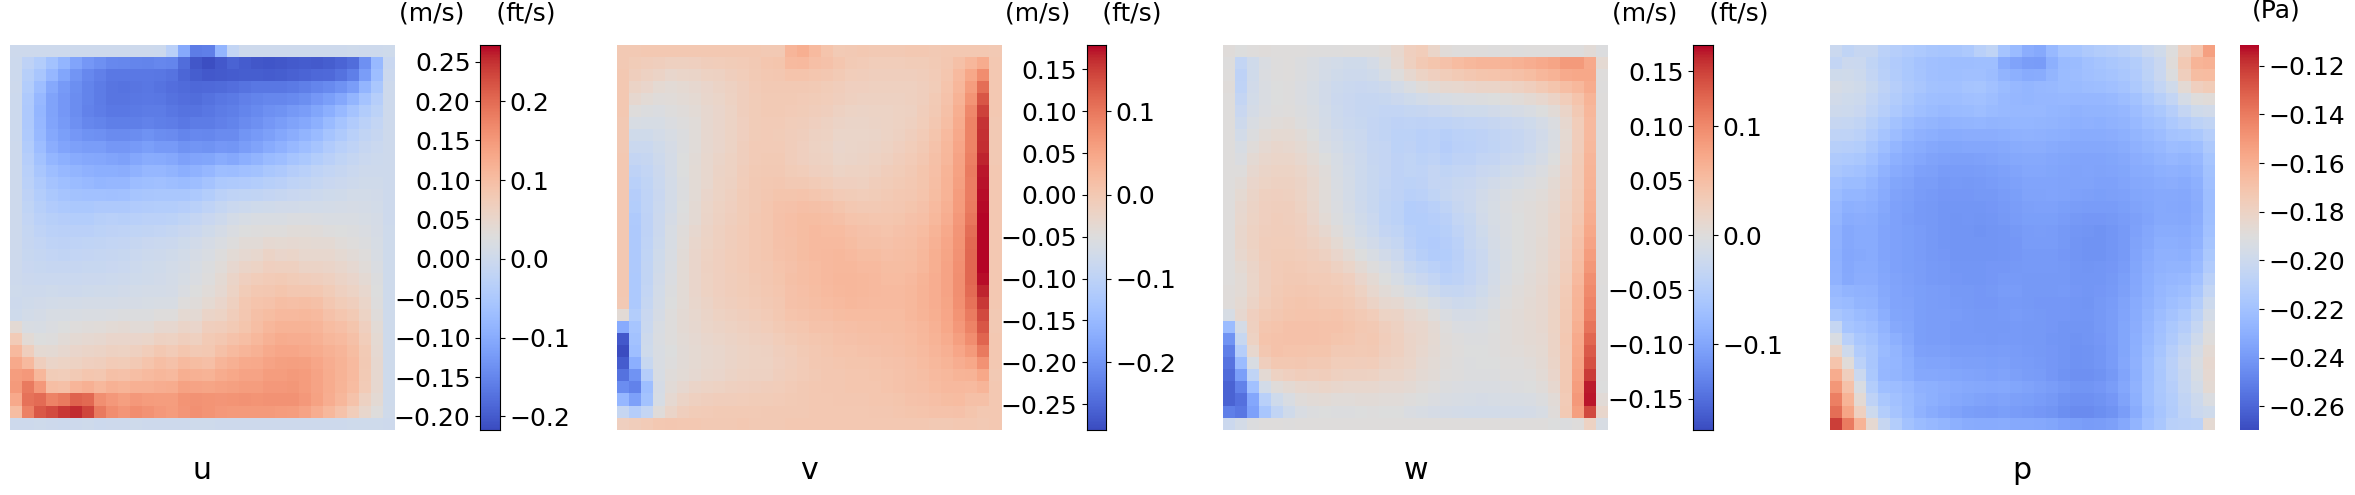

In [ ]:
batch_ind = 1
z = 8 # 0~16

matplotlib.rcParams.update({'font.size': 18})
for bnd_mx, mag_mx, xyz_deltas, cfd_mx in ds_test.skip(batch_ind).take(1):
    pred_mx = generator.predict([bnd_mx[0:1,:,:,:,:], mag_mx[0:1,:,:,:,:], xyz_deltas[0:1,:]])

    u_min, u_max = np.amin(cfd_mx[0,:,:,z,0], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,0], axis=(0,1))
    v_min, v_max = np.amin(cfd_mx[0,:,:,z,1], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,1], axis=(0,1))
    w_min, w_max = np.amin(cfd_mx[0,:,:,z,2], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,2], axis=(0,1))
    p_min, p_max = np.amin(cfd_mx[0,:,:,z,3], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,3], axis=(0,1))
    bnds = [[u_min, u_max], [v_min, v_max], [w_min, w_max], [p_min, p_max]]
    uvw = ["u", "v", "w"]

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
    for i in range(3):
        ax[i] = sns.heatmap(cfd_mx.numpy()[0,:,:,z,i].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
        ax[i].invert_yaxis()
        ax[i].axis('off')
        ax[i].set_title(uvw[i], y=-0.15)
        ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
        cbar0 = ax[i].collections[0].colorbar

        pos = cbar0.ax.get_position()
        #newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
        #newlabel = (newpos*3.28084).round(2)

        pos.x0 += 0.02
        pos.x1 += 0.02
        ax1 = cbar0.ax
        ax1.set_aspect('auto')
        ax1.set_position(pos)
        ax1.yaxis.set_ticks_position('left')
        ax1.yaxis.set_label_position('left')
        ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

        ax2 = ax1.twinx()
        ax2.set_position(pos)
        ax2.set_ylim([bnds[i][0], bnds[i][1]])
        ax2.yaxis.set_ticks_position('right')
        ax2.yaxis.set_label_position('right')
        #ax2.set_yticks(newpos)
        #ax2.set_yticklabels(newlabel)

    ax[3] = sns.heatmap(cfd_mx.numpy()[0,:,:,z,3].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
    ax[3].invert_yaxis()
    ax[3].axis('off')
    ax[3].set_title("p", y=-0.15)
    # ax[3].collections[0].colorbar.outline.set_visible(True)
    cbar3 = ax[3].collections[0].colorbar
    cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
    cbar3.ax.locator_params(nbins=10)

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
    for i in range(3):
        ax[i] = sns.heatmap(pred_mx[0,:,:,z,i].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
        ax[i].invert_yaxis()
        ax[i].axis('off')
        ax[i].set_title(uvw[i], y=-0.15)
        ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
        cbar0 = ax[i].collections[0].colorbar

        pos = cbar0.ax.get_position()
        #newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
        #newlabel = (newpos*3.28084).round(2)

        pos.x0 += 0.02
        pos.x1 += 0.02
        ax1 = cbar0.ax
        ax1.set_aspect('auto')
        ax1.set_position(pos)
        ax1.yaxis.set_ticks_position('left')
        ax1.yaxis.set_label_position('left')
        ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

        ax2 = ax1.twinx()
        ax2.set_position(pos)
        ax2.set_ylim([bnds[i][0], bnds[i][1]])
        ax2.yaxis.set_ticks_position('right')
        ax2.yaxis.set_label_position('right')
        #ax2.set_yticks(newpos)
        #ax2.set_yticklabels(newlabel)

    ax[3] = sns.heatmap(pred_mx[0,:,:,z,3].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
    ax[3].invert_yaxis()
    ax[3].axis('off')
    ax[3].set_title("p", y=-0.15)
    cbar3 = ax[3].collections[0].colorbar
    cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
    cbar3.ax.locator_params(nbins=10)

In [ ]:
csv_file_pth = "/content/drive/MyDrive/Indoor_model_1118/Indoor_model_loss_uvwp_0801/Indoor_model_loss_uvwp_0801_0"
df = pd.read_csv(csv_file_pth)
df

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,561
0,0.025609,0.028518,0.031564,0.028034,0.027863,0.029743,0.024299,0.028843,0.021198,0.030067,...,0.029783,0.025119,0.027720,0.026555,0.027299,0.027328,0.029935,0.026565,0.028919,0.028139
1,0.024429,0.028295,0.034425,0.028504,0.027712,0.028672,0.024899,0.029675,0.021338,0.030257,...,0.030802,0.027489,0.027814,0.026381,0.025053,0.030066,0.023421,0.033482,0.028340,0.023558
2,0.025248,0.028837,0.030700,0.028299,0.029199,0.029294,0.024721,0.029569,0.021723,0.030315,...,0.030714,0.025211,0.028177,0.025896,0.024951,0.026942,0.024536,0.026128,0.033248,0.029693
3,0.023906,0.028853,0.030937,0.029087,0.027665,0.029743,0.024061,0.028806,0.021862,0.029786,...,0.030644,0.024823,0.027796,0.026689,0.024822,0.027652,0.025187,0.026567,0.030323,0.024075
4,0.023838,0.029310,0.032996,0.028722,0.027006,0.028105,0.023376,0.030129,0.023266,0.029248,...,0.030953,0.025314,0.027660,0.026493,0.026093,0.027043,0.024224,0.027588,0.028233,0.023711
5,0.024258,0.028580,0.031001,0.028289,0.027216,0.029082,0.025496,0.030398,0.021226,0.029594,...,0.029946,0.025184,0.028136,0.027296,0.026157,0.029551,0.023867,0.026102,0.027091,0.023847
6,0.023992,0.028184,0.032287,0.029107,0.027326,0.028192,0.022922,0.030981,0.022130,0.029397,...,0.030013,0.025753,0.028078,0.027419,0.024873,0.027572,0.025060,0.026877,0.029974,0.023737
7,0.024794,0.030107,0.031538,0.030023,0.028306,0.027983,0.022894,0.027841,0.021481,0.031688,...,0.032478,0.026702,0.028214,0.026785,0.025355,0.029416,0.027004,0.025853,0.026816,0.023322
8,0.024231,0.028445,0.032185,0.028333,0.027458,0.028159,0.022865,0.028323,0.021008,0.030068,...,0.029750,0.024877,0.030808,0.028197,0.025398,0.027914,0.029734,0.026410,0.026753,0.023121
9,0.023837,0.028218,0.031764,0.028469,0.027282,0.028823,0.023125,0.028437,0.024056,0.031059,...,0.029168,0.025267,0.027275,0.025499,0.025607,0.026411,0.023251,0.027089,0.027298,0.028188


In [ ]:
df.mean(axis=1)

0     0.026953
1     0.026945
2     0.026961
3     0.026724
4     0.026800
5     0.026757
6     0.026708
7     0.026760
8     0.026677
9     0.026681
10    0.026650
11    0.026714
12    0.026558
13    0.026530
14    0.026530
15    0.026571
16    0.026639
17    0.026535
18    0.026494
19    0.026499
20    0.026301
21    0.026339
22    0.026474
23    0.026389
24    0.026402
25    0.026460
26    0.026255
27    0.026241
28    0.026298
29    0.026214
30    0.026388
31    0.026193
32    0.026147
33    0.026032
34    0.026167
35    0.026228
36    0.026134
37    0.026069
38    0.026162
39    0.026073
40    0.025985
41    0.026029
42    0.026074
43    0.025936
44    0.025972
45    0.025931
46    0.025874
47    0.025905
48    0.025872
49    0.025872
dtype: float64

<Axes: >

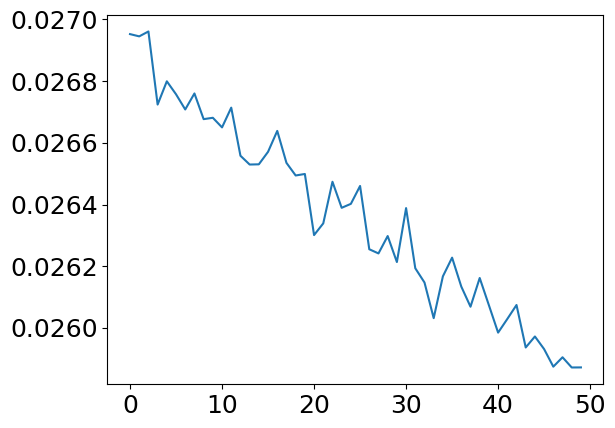

In [ ]:
df.mean(axis=1).plot()

In [ ]:
# tensorflow approach ==========================================
# Create test dataset 3000
test_batch_size = 512
test_folder_path = "/content/drive/MyDrive/Indoor_model_1118/Indoor_Dataset_D_test/Mag_High_Res_Dataset"
test_3000_filelist = sorted(glob.glob(npz_folder_path + '/*.npz'), key = lambda path: int(path.replace(".npz","").split("indoor_mag_highres_iteration_")[1]))
ds_3000_test = tf.data.Dataset.from_tensor_slices(test_3000_filelist)
ds_3000_test = ds_3000_test.flat_map(get_data_wrapper)
ds_3000_test = ds_3000_test.map(set_shape)
ds_3000_test = ds_3000_test.batch(batch_size)

In [ ]:
# tensorflow approach ==========================================
epoch_list = range(200, 255, 5)
mean_loss_list = []
for k in epoch_list:
    start = time.time()
    g_filename = '/content/drive/MyDrive/Indoor_model_1118/Archive_model/0801_uvwp/Indoor_model_uvwp_0801_%06d.h5' % (k)
    model = load_model(g_filename, compile=False)
    loss_list = []
    for i, (bnd_mx, mag_mx, xyz_deltas, cfd_mx) in enumerate(ds_3000_test):
        generated_images = model.predict([bnd_mx, mag_mx, xyz_deltas])
        loss_factor = 10.0
        gen_loss = MeanAbsoluteError()(generated_images, cfd_mx, sample_weight=K.abs(tf.subtract(bnd_mx[:,:,:,:,4], 0.25))) * loss_factor
        loss_list.append(gen_loss.numpy())
    mean_loss_list.append(np.mean(loss_list))
    print('Time for epoch {} is {} sec'.format(k, time.time()-start))
df = pd.DataFrame({"epoch": epoch_list, "loss": mean_loss_list})
df.to_csv("/content/drive/MyDrive/Indoor_model_1118/Indoor_test_loss_uvwp_0801.csv", index=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step
Time for epoch 220 is 311.9782245159149 sec
1/1 [==============================] - 0s 28ms/step
Time for epoch 225 is 312.0495226383209 sec
1/1 [==============================] - 0s 29ms/step
Time for epoch 230 is 312.15506863594055 sec
1/1 [==============================] - 0s 32ms/step
Time for epoch 235 is 315.1405203342438 sec
1/1 [==============================] - 0s 29ms/step
Time for epoch 240 is 311.027631521225 sec
1/1 [==============================] - 0s 29ms/step
Time for epoch 245 is 313.7013213634491 sec
1/1 [==============================] - 0s 33ms/step
Time for epoch 250 is 304.9590194225311 sec


Text(0.5, 1.0, 'Testing Loss Trajectory')

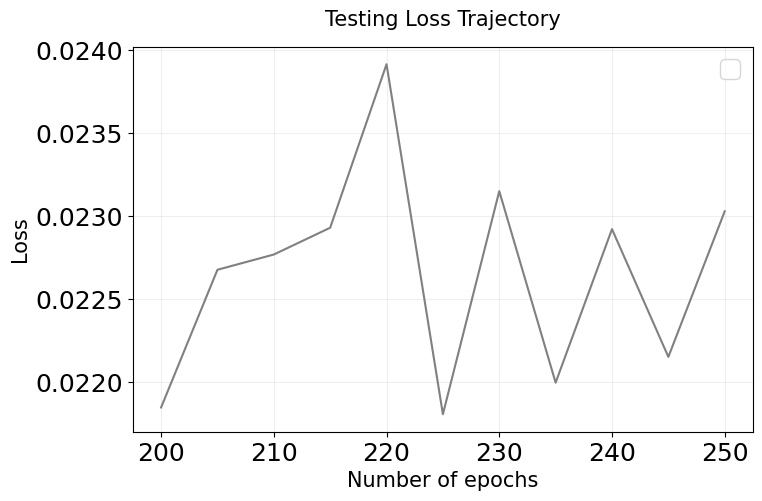

In [ ]:
df_test_lost = pd.read_csv("/content/drive/MyDrive/Indoor_model_1118/Indoor_test_loss_uvwp_0801.csv")

plt.figure(figsize = (8, 5))
plt.plot(df_test_lost.epoch, df_test_lost.loss, color='grey')
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Testing Loss Trajectory', fontsize=15, pad = 15)